# Fenics to DGL
Some notes and functions on how to save graph data with spatial location and values from Fenics to DGL

In [1]:
# Fenics
from fenics import *
from dolfin import *
from mshr import *

# DGL
import dgl
from dgl.data.utils import load_graphs, save_graphs

# Others
import torch
import numpy as np
import math
import matplotlib.pyplot as plt 

Using backend: pytorch


## 1. Create mesh

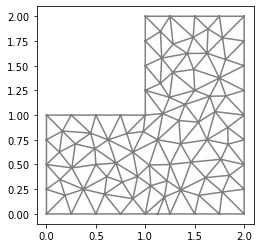

In [3]:
rectangle1 = Rectangle(Point(0, 0), Point(2, 1))
rectangle2 = Rectangle(Point(1, 1), Point(2, 2))
mesh = generate_mesh(rectangle1 + rectangle2, 8)
plot(mesh)

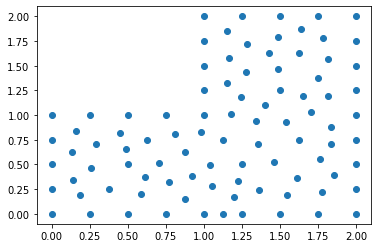

In [4]:
mesh.coordinates()
plt.scatter(mesh.coordinates()[:,0], mesh.coordinates()[:,1])

## 2. Solve PDE via Fenics

In [5]:
rectangle1 = Rectangle(Point(0, 0), Point(2, 1))
rectangle2 = Rectangle(Point(1, 1), Point(2, 2))
mesh = generate_mesh(rectangle1 + rectangle2, 8)

V = FunctionSpace(mesh, 'P', 1)

def boundary(x, on_boundary):
    return on_boundary
u_D = Expression('1 - 1*x[0]*x[0] + 2*x[1]*x[1]', degree=2)
bc = DirichletBC(V, u_D, boundary)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

u = Function(V)
solve(a == L, u, bc)

## 3. Save data and mesh with DGL graph

### Utilities

In [6]:
def get_edges(mesh):
    '''
    Get two connectivity lists of nodes, edges are directed from
    sources to destinations
    Required by DGL in the graph creation
    
    Example:
    Nodes [0, 0, 1], [0, 1, 2] imply this connectivity
    0->0, 0->1, 1->2
    '''
    mesh.init(0,1)
    sources = []
    destinations = []
    for v in vertices(mesh):
        idx = v.index()
        neighbors = [Edge(mesh, i).entities(0) for i in v.entities(1)]
        neighbors = np.array(neighbors).flatten()
        # Remove own index from neighborhood
        neighbors = neighbors[np.where(neighbors != idx)[0]]
        for n in neighbors:
            sources.append(int(idx))
            destinations.append(int(n))
    return sources, destinations

def to_node_values(u, mesh):
    '''
    Get list of values corresponding to the nodes
    '''
    vals = []
    for pos in mesh.coordinates():
        vals.append(u(Point(pos)))
    return torch.tensor(vals)

### Create DGL graph from Fenics data

In [7]:
G = dgl.DGLGraph()
G.add_nodes(mesh.num_vertices())
src, dest = get_edges(mesh)
G.add_edges(src, dest)
G.ndata['x'] = torch.tensor(mesh.coordinates()[:,0])
G.ndata['y'] = torch.tensor(mesh.coordinates()[:,1])
G.ndata['value'] = torch.tensor(to_node_values(u, mesh))

/home/cbhua/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
<ipython-input-7-cc8244eab967>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G.ndata['value'] = torch.tensor(to_node_values(u, mesh))


In [16]:
print(G)

Graph(num_nodes=9985, num_edges=59246,
      ndata_schemes={'y': Scheme(shape=(), dtype=torch.float64), 'value': Scheme(shape=(), dtype=torch.float64), 'x': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={})


### Save

In [8]:
# Create data folder and save graph
import os
path = "data/"
if not os.path.exists(path): os.makedirs(path)
save_graphs(path+"test.bin", G)

## 4. Load graph and plot

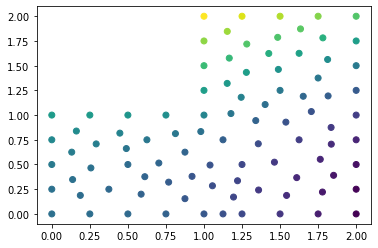

In [9]:
# load_graphs returns a tuple of graphs with a list of... stuff? So we have to index
# twice with [0], [0]
G1 = load_graphs(path+"test.bin")[0][0]
plt.scatter(G1.ndata['x'], G1.ndata['y'], c=G1.ndata['value'])

In [18]:
G1

Graph(num_nodes=92, num_edges=480,
      ndata_schemes={'y': Scheme(shape=(), dtype=torch.float64), 'value': Scheme(shape=(), dtype=torch.float64), 'x': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={})

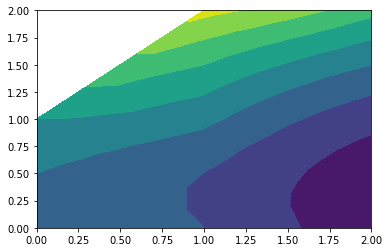

In [10]:
plt.tricontourf(G1.ndata['x'], G1.ndata['y'], G1.ndata['value'])

## 5. Time series graphs

In [11]:
# Mesh Generation
c=5000
mesh = Rectangle(Point(-2., -2.),Point(2., 2.))
mesh = generate_mesh(mesh, 80)
V=FunctionSpace(mesh, "Lagrange", 1)

# Time variables
dt = 0.000004; t = 0; T = 0.001

# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

bc = DirichletBC(V, 0, "on_boundary")
A, b = assemble_system(a, L, bc)

u=Function(V)

# We save the values in these lists
values = []
times = []

while t <= T:
    A, b = assemble_system(a, L, bc)
    delta = PointSource(V, Point(0, 0), sin(c * 10 * t))
    delta.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    print('Time {:.6f}/{:.6f}s'.format(t, T), end='\r')
    t += dt
    
    # Reduce the range of the solution so that we can see the waves
    j = 0
    for i in u.vector():
        i = min(.01, i)
        i = max(-.01, i)
        u.vector()[j] = i;
        j += 1
    values.append(to_node_values(u, mesh))
    times.append(t-dt)

### Saving graph timeseries
This will take some time, reason why we added `tqdm`

NOTE: The size of the resulting `.bin` file may be very large, in the order of GBs!

In [12]:
from tqdm import tqdm

Gs = []
for i in tqdm(range(len(values))):
    G = dgl.DGLGraph()
    G.add_nodes(mesh.num_vertices())
    src, dest = get_edges(mesh)
    G.add_edges(src, dest)
    G.ndata['x'] = torch.tensor(mesh.coordinates()[:,0])
    G.ndata['y'] = torch.tensor(mesh.coordinates()[:,1])
    G.ndata['value'] = values[i]
    Gs.append(G)

# We conveniently save each graph's metadata with labels
graph_labels = {"timestamp": torch.tensor(times)}
save_graphs(path+"test_timeseries.bin", Gs, graph_labels)

100%|██████████| 251/251 [00:47<00:00,  5.24it/s]


### Loading and plotting
This can take some time. Reduce the numer of frames (e.g. ~20) to see a faster result

In [15]:
# Loading
Graphs, timestamps = load_graphs(path+"test_timeseries.bin")
T = list(timestamps.values())[0] # convert from dict

# Plotting
from matplotlib import animation
from IPython.display import HTML

# We get maximum and minimum values of the data for plotting
vmax = 0
vmin = 0
for G in Graphs:
    top = G.ndata['value'].max()
    bottom = G.ndata['value'].min()
    if vmax < top:
        vmax = top
    if vmin > bottom:
        vmin = bottom

    
fig, ax = plt.subplots(figsize=(8,8))
ax = fig.add_subplot(111)
plt.close()

# Initialization function: plot the background of each frame
def init():
    ax.tricontourf(Graphs[0].ndata['x'],
                        Graphs[0].ndata['y'],
                        Graphs[0].ndata['value'], vmin=vmin, vmax=vmax, cmap='Blues')

# Animation function which updates figure data.  This is called sequentially
def update(i):
    ax.tricontourf(Graphs[i].ndata['x'],
                        Graphs[i].ndata['y'],
                        Graphs[i].ndata['value'], vmin=vmin, vmax=vmax, cmap='Blues')    

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, update, frames=len(Graphs), init_func = init,
                               interval=20, blit=False)

# Call function to display the animation
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [14]:
!pip3 install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=48100fa13da252fab56a6d839662aa513bd5725decfc2fadbab472d24e51e908
  Stored in directory: /home/cbhua/.cache/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg
